In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU,LSTM,Dense,BatchNormalization,Dropout,Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('../data/google_stock.csv')
data.shape

(3809, 7)

In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
1,2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2,2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
3,2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
4,2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100


In [4]:
data.drop('Date',axis=1,inplace=True)
data.drop('Volume',axis=1,inplace=True)
data.drop('Adj Close',axis=1,inplace=True)

In [5]:
data.head()

,Open,High,Low,Close
0,49.813286,51.835709,47.800831,49.982655
1,50.316402,54.336334,50.062355,53.952770
2,55.168217,56.528118,54.321388,54.495735
3,55.412300,55.591629,51.591621,52.239193
4,52.284027,53.798351,51.746044,52.802086


### Train, Val, Test spliting

In [6]:
train_org = data.iloc[:3048,:]
test = data.iloc[3048:,:]
train_org.shape, test.shape   

((3048, 4), (761, 4))

In [7]:
scaler = MinMaxScaler()
train_org = scaler.fit_transform(train_org)
test = scaler.transform(test)

In [8]:
train = train_org[:2287, :]
val = train_org[2287:, :]
train.shape, val.shape                     # train: 2287 seqs, val: 761 seqs, test: 761 seqs

((2287, 4), (761, 4))

In [9]:
X_train=[]
y_train=[]

for i in range(0,train.shape[0]-31):         # idea: use 30 previous day to predict next 1 day
    X_train.append(train[i:i+30,:])
    y_train.append(train[i+30:i+31,0])

X_train,y_train=np.array(X_train),np.array(y_train)
X_train.shape,y_train.shape

((2256, 30, 4), (2256, 1))

In [10]:
X_val=[]
y_val=[]

for i in range(0,val.shape[0]-31):         # idea: use 30 previous day to predict next 1 day
    X_val.append(val[i:i+30,:])
    y_val.append(val[i+30:i+31,0])

X_val,y_val=np.array(X_val),np.array(y_val)
X_val.shape,y_val.shape

((730, 30, 4), (730, 1))

In [11]:
X_test=[]
y_test=[]

for i in range(0,test.shape[0]-31):         # idea: use 30 previous day to predict next 1 day
    X_test.append(test[i:i+30,:])
    y_test.append(test[i+30:i+31,0])

X_test,y_test=np.array(X_test),np.array(y_test)
X_test.shape,y_test.shape

((730, 30, 4), (730, 1))

### Modeling

In [12]:
model = Sequential()

model.add(GRU(units=32, activation='tanh', return_sequences=False,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1, activation='linear'))

In [13]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt,loss='mse')

In [14]:
history = model.fit(X_train, y_train, epochs=60, batch_size=32,
                    validation_data=(X_val, y_val), verbose=1)

Train on 2256 samples, validate on 730 samples
Epoch 1/60
2256/2256 [==============================] - 7s 3ms/sample - loss: 0.0023 - val_loss: 0.0053
Epoch 2/60
2256/2256 [==============================] - 1s 328us/sample - loss: 5.7615e-05 - val_loss: 0.0022
Epoch 3/60
2256/2256 [==============================] - 1s 228us/sample - loss: 4.4289e-05 - val_loss: 0.0022
Epoch 4/60
2256/2256 [==============================] - 1s 225us/sample - loss: 3.8376e-05 - val_loss: 0.0020
Epoch 5/60
2256/2256 [==============================] - 0s 209us/sample - loss: 3.4715e-05 - val_loss: 0.0018
Epoch 6/60
2256/2256 [==============================] - 0s 203us/sample - loss: 3.2185e-05 - val_loss: 0.0017
Epoch 7/60
2256/2256 [==============================] - 1s 222us/sample - loss: 3.0163e-05 - val_loss: 0.0015
Epoch 8/60
2256/2256 [==============================] - 0s 216us/sample - loss: 2.9052e-05 - val_loss: 0.0012
Epoch 9/60
2256/2256 [==============================] - 0s 213us/sample - loss:

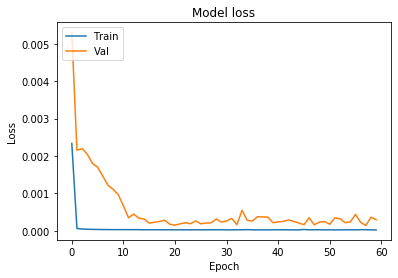

In [15]:
epoch_range=range(1,50+1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.xticks([x for x in range(epoch+1)])
plt.legend(['Train','Val'],loc='upper left')
plt.show()

### Evaluation

In [16]:
y_pred = model.predict(X_test)
y_pred.shape

(730, 1)

In [17]:
scale = scaler.scale_[0]
scale

0.0013565203795903229

In [18]:
bias = scaler.min_[0]
bias

-0.06702540200800232

In [19]:
y_test = (y_test-bias)/scale
y_pred = (y_pred-bias)/scale

In [20]:
y_test = y_test.reshape(730, 1)
y_pred = y_pred.reshape(730, 1)

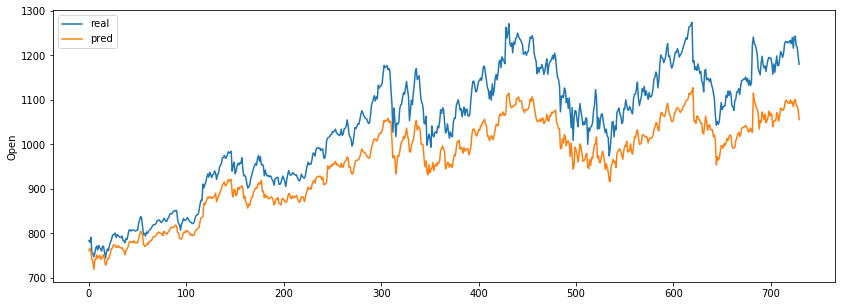

In [21]:
plt.figure(figsize=(14,5))
plt.plot(y_test,label='real')
plt.plot(y_pred,label='pred')
plt.ylabel('Open')
plt.legend()
plt.show()

In [22]:
model.save('../model/GRU_seq2vec_mutilvariate.h5')